In [ ]:
pip install scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models

In [21]:
# Cargamos los datos
df_spectra = pd.read_csv(r'C:\Users\op354\OneDrive\Documentos\Oscar\UG\Repositorio Github\ejerciosytareas-Oscarraul28\balanced_spectra_features.csv')

# Cargamos el archivo de espectros
datos = np.load(r'C:\Users\op354\OneDrive\Documentos\Oscar\UG\Repositorio Github\ejerciosytareas-Oscarraul28\balanced_spectra_flux.npz', allow_pickle=True)
targetids = datos['targetids']
f_arrays = datos['flux_arrays']

# Preparamos para meter los datos:
X = []
Y = []

for i in range(len(targetids)):
    # Buscamos el tipo espectral correspondiente a este targetid
    spectype_reng = df_spectra.loc[df_spectra['targetid'] == targetids[i], 'spectype']
    if spectype_reng.empty:
        continue
    spectype = spectype_reng.values[0]

    # Asignamos etiquetas numéricas:
    if spectype == 'GALAXY':
        Y.append(0)
    elif spectype == 'STAR':
        Y.append(1)
    elif spectype == 'QSO':
        Y.append(2)
    else:
        continue

    # Agregamos el espectro a X:
    X.append(f_arrays[i])

# Convertimos a arrays (numpy)
X = np.asarray(X)
Y = np.asarray(Y)

print("Formas finales:")
print("X:", X.shape)
print("Y:", Y.shape)

Formas finales:
X: (492, 7781)
Y: (492,)


In [26]:
# Dividimos los datos
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=112)

#Hacemos el escalamiento de datos, esto para dejar en claro que queremos las imagenes solo en escala de grises
escalador = StandardScaler()
X_train_esc = escalador.fit_transform(X_train)
X_test_esc = escalador.transform(X_test)
#Si fuera a color seria 3 canales (RGB), pero como es en grises solo trabajamos con 1 canal
X_train_esc = np.expand_dims(X_train_esc, axis=-1)
X_test_esc = np.expand_dims(X_test_esc, axis=-1)

print(X_train_esc.shape)  # (n_samples, longitud_del_espectro, 1)

(344, 7781, 1)


In [31]:
#Implementamos una arquitectura de redes convolucionales para hacer nuestra clasificacion espectral

modelo = models.Sequential([
    layers.Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train_esc.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # 3 clases: GALAXY, STAR, QSO
])

modelo.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

modelo.summary()

c:\Users\op354\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 7777, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 3888, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 3884, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 1942, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 1940, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,651 (170.51 KB)

 Trainable params: 43,651 (170.51 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
#Entrenamos nuestro modelo:
history = modelo.fit(
    X_train_esc, y_train,
    validation_data=(X_test_esc, y_test),
    epochs=30,
    batch_size=16,
    verbose=1
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 496ms/step - accuracy: 0.8343 - loss: 0.5172 - val_accuracy: 0.8243 - val_loss: 0.4999
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - accuracy: 0.8285 - loss: 0.5254 - val_accuracy: 0.8243 - val_loss: 0.5042
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 404ms/step - accuracy: 0.8285 - loss: 0.5246 - val_accuracy: 0.8243 - val_loss: 0.4990
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.8256 - loss: 0.5270 - val_accuracy: 0.8311 - val_loss: 0.4931
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 401ms/step - accuracy: 0.8314 - loss: 0.5208 - val_accuracy: 0.8311 - val_loss: 0.4987
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 415ms/step - accuracy: 0.8343 - loss: 0.5161 - val_accuracy: 0.8243 - val_loss: 0.4960
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - accuracy: 0.8343 - loss: 0.5117 - val_accuracy: 0.8243 - val_loss: 0.4933
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 411ms/step - accuracy: 0.8314 - loss: 0.5170 - val_accuracy:

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.8311 - loss: 0.4835
Presicion en la prueba (Test): 0.831
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
              precision    recall  f1-score   support

      GALAXY       0.83      1.00      0.91       102
        STAR       0.84      0.91      0.88        23
         QSO       0.00      0.00      0.00        23

    accuracy                           0.83       148
   macro avg       0.56      0.64      0.59       148
weighted avg       0.70      0.83      0.76       148



c:\Users\op354\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\op354\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\op354\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

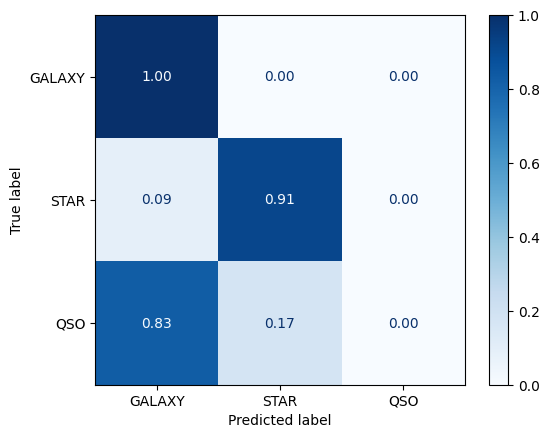

In [36]:
#Evaluamos el rendimiento:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

loss, acc = modelo.evaluate(X_test_esc, y_test)
print(f"Presicion en la prueba (Test): {acc:.3f}")

y_pred = np.argmax(modelo.predict(X_test_esc), axis=1)
print(classification_report(y_test, y_pred, target_names=['GALAXY', 'STAR', 'QSO']))

# Generamos nuestra matriz de confusión para visualizar mejor esto:
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['GALAXY','STAR','QSO'])
disp.plot(cmap='Blues', values_format='.2f')
plt.show()
